# Loading data for NER

In [1]:
import pandas as pd
import numpy as np

#load from folder data
# trainingdata300.csv loads the data file where the sentences are not longer than 300 words
data = pd.read_csv('data/trainingdata300.csv')

#fill missing values with 'forward fill' method
data = data.fillna(method="ffill")

In [2]:
data.tail(10)

,satzId,Wort,Attribut
4945007,55339,start,O
4945008,55339,Load,O
4945009,55339,amount,O
4945010,55339,setting,O
4945011,55339,SAFETY,O
4945012,55339,AND,O
4945013,55339,MAINTENANCE,O
4945014,55339,Lockable,O
4945015,55339,control,O
4945016,55339,panel,O


# Building dictionarys for embeddings

In [3]:
# build a list with all in the file occuring words 
words = list(set(data["Wort"].values))
n_words = len(words); n_words

82108

In [4]:
# build a list with all in the file occuring tags/attributes
tags = list(set(data["Attribut"].values))
n_tags = len(tags); n_tags

7

In [5]:
# function to retrieve a sentence from the data set. 
# This is done by grouping by the satzId

class SentenceGetter(object):    
    def __init__(self, data):
        #self.n_sent = -1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Wort"].values.tolist(),
                                                s["Attribut"].values.tolist())]
        self.grouped = self.data.groupby("satzId").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    #method to get the next sentence. (This method will not be used by us)
    # def get_next(self):
    #     try:
    #         self.n_sent += 1
    #         s = self.grouped[self.n_sent]
    #         return s
    #     except:
    #         return None

In [6]:
# initialize the sentenceGetter
getter = SentenceGetter(data)
# array of the sentences
sentences = getter.sentences

In [7]:
# every time this method is is called we will get the next sentence
#sent = getter.get_next()
#print(sent)

In [8]:
# create dictionary for mapping words into indexes. If word is "UNK" (unknown) the index is 1. If word is "PAD" (padding) the index is 0
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
# dictionary to get the words from a index
idx2word = {i: w for w, i in word2idx.items()}

# create dictionary for mapping tags/attributes into indexes. If tag is "PAD" (padding) the index is 0
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
# dictionary to get the tag from a index
idx2tag = {i: w for w, i in tag2idx.items()}

In [9]:
# Examples
print(word2idx["Broan"])
print(tag2idx["B-Brand"])

69639
3


# Building final structures for the model

In [10]:
from keras.preprocessing.sequence import pad_sequences

# prepare the tokens for padding. cut sentences after 75 words and cut words after 10 characters.
max_len = 75
max_len_char = 10

# map the words of all sentences into indexes. The Result is a list of sentences. Every sentence is a list of words represented as indexes.
X_word = [[word2idx[w[0]] for w in s] for s in sentences]

# pad or cut the sequences to a maximum of 75 words.
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

In [11]:
# preparations for character embedding

# build a set with every occuring character
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

# create dictionary for mapping characters into indexes. If char is "UNK" (unknown) the index is 1. If char is "PAD" (padding) the index is 0
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

1838


In [12]:
# map the characters of all words in all sentences into indexes. The Result is a list of sentences. 
# Every sentence is a list of words. And every word is a list of characters represented as indexes.
# The sequences are padded or cut at a maximum of 10 characters per word (in the third for loop)

X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [13]:
# map the tags/attributes of all sentences into indexes. The Result is a list of sentences. Every sentence is a list of tags represented as indexes.
# y is the variable we want to learn/train
y = [[tag2idx[w[1]] for w in s] for s in sentences]

# pad or cut the sequences to a maximum of 75 words.
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [14]:
from sklearn.model_selection import train_test_split

# splitting dataset into training and test. traingsize = 0.9, testsize = 0.1
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

# Building the model architecture

In [15]:
#imports needed for the model
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [16]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc]) # combining word and character layers
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)

In [17]:
# compiling the model with the above layers, 
# using standard adam optimizer and sparse categorical crossentropy optimizing accuracy 
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [18]:
#printing layer information and summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 10)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 75, 10, 10)   18400       input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 75, 20)       1642200     input_1[0][0]                    
______________________________________________________________________________________________

# Training the model

In [26]:
# hier vielleicht anderes Training einfügen?
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=1)

Epoch 1/10
351/986 [=========>....................] - ETA: 1:54 - loss: 0.5843 - acc: 0.9158

In [ ]:
# training step
# with early stopping to let val_loss decide when training is done
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    # default: 0.0001 -> wenn höher, stoppt es eher, bei 0.00001:
    min_delta=0.0005,
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True)
# fitting the model with:
# 1. List of sentences containing list of words
# 2. List of sentences containing list of words containing list of characters
# 3. attributes we are trying to learn/tag
history = model.fit([X_word_tr,
                    np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=64,
                    epochs=50,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[early_stop])


In [ ]:
# save history as dataframe
hist = pd.DataFrame(history.history)

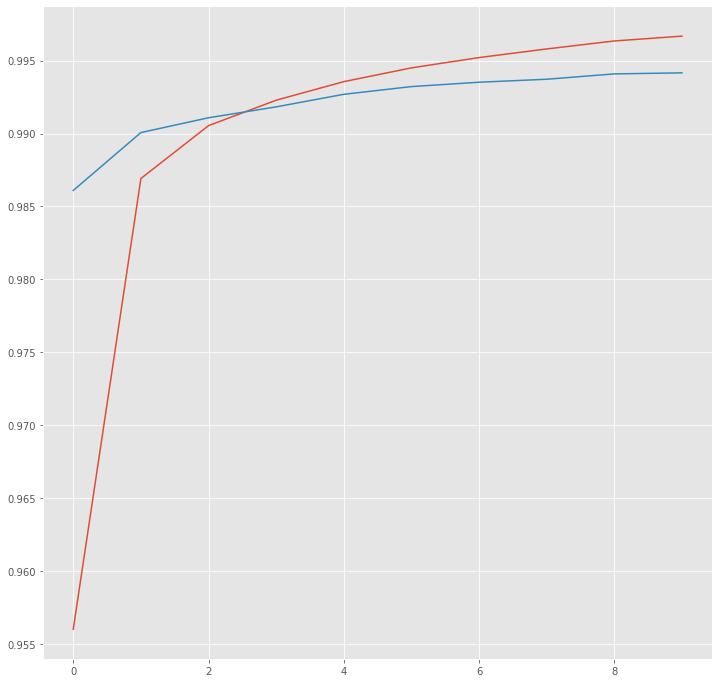

In [ ]:
#plotting accuracy and validation accuracy


# hist statt history.history?


import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(6, 6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing the model on unseen data

In [ ]:
# predicting the test data with the trained model
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])

In [ ]:
# using the 12th sentence of the test data as an example
i = 12
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

## Calculating metrics for confusion matrix

In [ ]:
tn, tp_brand, tp_modelnumber, fp, fn_brand, fn_modelnumber = 0,0,0,0,0,0

#for x in range(0, 3891):
for x in range(len(X_word_te)):
    p = np.argmax(y_pred[x], axis=-1)
    #print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
    #print(30 * "=")
    for w, t, pred in zip(X_word_te[x], y_te[x], p):
        if w != 0:
            #print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))
            if(idx2tag[t] == idx2tag[pred]):
                if(idx2tag[t]=='O'):
                    #print('TN')
                    tn += 1
                elif('Brand' in idx2tag[t]):
                    #print('TP-Brand')
                    tp_brand += 1
                elif('Modelnumber' in idx2tag[t]):
                    #print('TP-Modelnumber')
                    tp_modelnumber += 1
            else:
                if(idx2tag[t]=='O'):
                    #print('FP')
                    fp += 1
                elif('Brand' in idx2tag[t]):
                    #print('FN-Brand')
                    fn_brand += 1
                elif('Modelnumber' in idx2tag[t]):
                    #print('FN-Modelnumber')
                    fn_modelnumber += 1

print('TN:', tn, '\nTP-Brand', tp_brand, '\nTP-Modelnumber', tp_modelnumber, '\nFP', fp, '\nFN-Brand', fn_brand, '\nFN-Modelnumber', fn_modelnumber)

recall_brand = tp_brand / (fn_brand+tp_brand)
precision_brand = tp_brand / (tp_brand+fp)
print('\nRecall Brand:', recall_brand, '\nPrecision Brand:', precision_brand)

recall_modelnumber = tp_modelnumber / (fn_modelnumber+tp_modelnumber)
precision_modelnumber = tp_modelnumber / (tp_modelnumber+fp)
print('\nRecall Modelnumber', recall_modelnumber, '\nPrecision Modelnumber', precision_modelnumber)


TN: 218204 
TP-Brand 7643 
TP-Modelnumber 6870 
FP 696 
FN-Brand 113 
FN-Modelnumber 569

Recall Brand: 0.9854306343476018 
Precision Brand: 0.9165367550065955

Recall Modelnumber 0.923511224626966 
Precision Modelnumber 0.9080095162569389
